In [42]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
#Re-import as per "Read amplicons and summaries.ipynb"

#Import the data and flip into a multi index 
df = pd.read_csv('../Data/allele_counts.tsv', header = [0,1,2], index_col = 0, sep='\t')
df = df.stack([0,1,2])
df = df.reorder_levels([1,0,2,3])
df = df.to_frame()  #puts everything back in a dataframe
df.columns = ['Reads']
df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
df['Well'] = df.index.get_level_values(1)
df['Amplicon'] = df.index.get_level_values(2)
df['Genotype'] = df.index.get_level_values(3)
df[['Patient', 'one', 'two']] = df['Amplicon'].str.split('_', expand = True)
df = df.drop(columns = ['one', 'two'])

#Import information about plate cell type and patient
key = pd.read_excel('../Data/Amplicon_metadata_fixed.xlsx', sheet_name = 'PlateID')
key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells', 'fcs-fle' ], axis=1)
key.rename(columns = {'Comments2':'Plate'}, inplace = True)
key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)

#Make a dictionary to associate plates with patients and plate with cell type
plate_pt_dict = dict(zip(key.Plate, key.Patient))
plate_cell_dict = dict(zip(key.Plate, key.Celltype))

#Set up some lists for iteration
patients = ['RN', 'EL', 'GR']
plates = df['Plate'].drop_duplicates().to_list()
amplicons = df['Amplicon'].drop_duplicates().to_list()
genos = df['Genotype'].drop_duplicates().to_list()
wells = df['Well'].drop_duplicates().to_list()

In [44]:
#Now just look at RN data, and apply filters to identify cells with enough reads/amplicon
RN_allele_plate = df.loc[df['Patient'].isin(['RN'])] #Make df with just RN data
RN_allele_plate = RN_allele_plate.drop(columns = 'Patient') #Drop the Patient ID column and other unwanted cols

#Find the cells/wells that contain >100 reads for the selected amplicons and turn into a list 
#Re-arrange the table
df2 = RN_allele_plate.groupby(['Plate', 'Well', 'Amplicon']).sum()
df2 = df2.unstack()
df2 = df2.iloc[:, 0:4] #Just keep the columns of interest
df2 = df2.loc[(df2 >= 100).all(axis=1)] #df2 contains just the rows with cells we want - use this to create a filter or key
df2 = df2.stack()

#Make the plate and well info a single column and put in a list
df2['Plate'] = df2.index.get_level_values(0)  #These lines send indexes to columns
df2['Well'] = df2.index.get_level_values(1)
df2['Plate_Well'] = df2['Plate'].astype(str) + '_' + df2['Well'].astype(str)
RN_wells = df2['Plate_Well'].to_list() #RN_wells is the list of wells that fulfill the desired criteria

#Make a file with the allele counts per well for all wells
df3 = RN_allele_plate.groupby(['Plate', 'Well', 'Amplicon']).sum()
df3 = df3.unstack(2)
df3['Plate'] = df3.index.get_level_values(0)
df3['Cell_type'] = df3['Plate'].replace(plate_cell_dict)
df3.to_csv('../Results/Amp_counts/RN_all_cells_reads_per_amplicon.tsv',  sep = '\t')

In [45]:
#Extract data just for the desired cells/wells
RN_allele_plate['Plate_Well'] = RN_allele_plate['Plate'].astype(str) + '_' + RN_allele_plate['Well'].astype(str)
RN_allele_plate = RN_allele_plate[RN_allele_plate['Plate_Well'].isin(RN_wells)] #keep the wells identified before
RN_allele_plate = RN_allele_plate[RN_allele_plate['Amplicon'].isin(['RN_RUNX1_c', 'RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a'] )] #keep the amplicons that worked

#Calculates the allele frequency and saves the output into a .csv file
RN_allele_plate = RN_allele_plate.iloc[:, 0:1].unstack(level = 3)
RN_allele_plate['Total'] = RN_allele_plate.iloc[: , 0] + RN_allele_plate.iloc[: , 1]
RN_allele_plate['Mut_freq'] = RN_allele_plate.iloc[:, 0]/RN_allele_plate['Total']
RN_allele_plate.to_csv('../Results/Geno_counts/geno_counts_frequencies_raw_reads.tsv', index = None, sep = '\t')

#Convert into easily plottable format and save the output to a .csv file
RN_allele_plate = RN_allele_plate.drop(columns = ['Reads', 'Total'])
RN_allele_plate['Plate'] = RN_allele_plate.index.get_level_values(0)
RN_allele_plate['Amplicon'] = RN_allele_plate.index.get_level_values(2)
RN_allele_plate['Cell_type'] = RN_allele_plate['Plate'].replace(plate_cell_dict)
RN_allele_plate['Well'] = RN_allele_plate.index.get_level_values(1)
RN_allele_plate['Plate_Well'] = RN_allele_plate['Plate'].astype(str) + '_' + RN_allele_plate['Well'].astype(str)
RN_allele_plate.to_csv('../Results/Geno_counts/geno_counts_frequencies.tsv', index = None, sep = '\t')
 
#Make a list of cell types
#Note there are no neutrophils because the RUNX1_c amplicon isn't great (probably not expressed)
celltypes = RN_allele_plate['Cell_type'].drop_duplicates().to_list()

In [46]:
#Make lists of possible haplotypes
#possible haplotypes for 3 genotype system
first = ['Rw', 'Rh', 'RH']
second = ['_Sw', '_Sh', '_SH']
third = ['_Tw', '_Th', '_TH']
hap3 =[]

for a in first:
    for b in second:
        for c in third:
            hap3.append(a+b+c)
    
#possible haplotype for 2 genotype system
firsta = ['Rw', 'Rm']
seconda = ['_Sw', '_Sm']
thirda = ['_Tw', '_Tm']
hap2 =[]

for a in firsta:
    for b in seconda:
        for c in thirda:
            hap2.append(a+b+c)

In [47]:
#Assign three arbitrary genotypes - WT, het, hom
geno_assign3 = RN_allele_plate
conditions = [(geno_assign3['Mut_freq'] <= 0.25), (geno_assign3['Mut_freq'] > 0.25) & (geno_assign3['Mut_freq'] < 0.75), (geno_assign3['Mut_freq']) >= 0.75 ]
values = ['w', 'h', 'H']
geno_assign3['Genotype'] = np.select(conditions, values)
values3 = [0,1,2] #include a numerical score for number of mutations
geno_assign3['Order'] = np.select(conditions, values3)
geno_assign3 = geno_assign3.unstack(2)
geno_assign3 = geno_assign3.drop(columns = ['Mut_freq', 'Plate',  'Cell_type', 'Well', 'Plate_Well']) #drop unwanted columns

#Rearrange df
geno_assign3 = geno_assign3.stack()
geno_assign3 = geno_assign3.loc[geno_assign3['Amplicon'].isin(['RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a'])]  #drop RUNX1 cDNA for simplicity
geno_assign3 = geno_assign3.drop(columns = ['Amplicon'])
geno_assign3 = geno_assign3.unstack()
geno_assign3['Mut_score'] = geno_assign3.iloc[:, 3:6].sum(axis = 1)  #add the mutation scores together
geno_assign3 = geno_assign3.drop(columns = ['Order'])
geno_assign3.columns = ['RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a', 'Mut_score'] #renaming as something went funny in previous steps

geno_assign3['haplotype'] = 'R' + geno_assign3['RN_RUNX1_g'] + '_S' + geno_assign3['RN_SRSF2'] + '_T' + geno_assign3['RN_TET2a']
haps = geno_assign3['haplotype'].drop_duplicates().to_list()
geno_assign3['Cell_type'] = geno_assign3.index.get_level_values(0)
geno_assign3 = geno_assign3.replace({'Cell_type': plate_cell_dict})
geno_assign3 = geno_assign3.drop(columns = ['RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a'])
print('The number of haplotypes present using 3 genotypes is: ', len(haps)) # haplotypes (3 arbitrary classes, WT (W), heterozygote (h), homozygote (H))

The number of haplotypes present using 3 genotypes is:  17


In [48]:
#Plot three haplotype data
fig, axes = plt.subplots(2,2, figsize = (16,8))
fig.subplots_adjust(hspace = 1, wspace=.5)
ax = axes.ravel()
count = -1

for cell in celltypes:
    count += 1
    ax[count] = geno_assign3.loc[geno_assign3['Cell_type'].isin([cell])]['haplotype'].value_counts().plot(kind = 'bar', ax = ax[count])
    ax[count].set_title(str(cell)) 
    ax[count].set_ylabel('Number of cells')
    
fig.suptitle('3 haplotype count by cell type', fontsize=16)
fig.savefig('../Results/Haplotypes/Haplotype3_freq_cellype.png',dpi=300)     
plt.close() #Plot just goes to file and isn't displayed    

In [49]:
#Plot three haplotype data - by number of mutations
fig, axes = plt.subplots(2,2, figsize = (16,8))
fig.subplots_adjust(hspace = 1, wspace=.5)
ax = axes.ravel()
count = -1

for cell in celltypes:
    count += 1
    ax[count] = geno_assign3.loc[geno_assign3['Cell_type'].isin([cell])]['Mut_score'].value_counts().plot(kind = 'bar', ax = ax[count])
    ax[count].set_title(str(cell)) 
    ax[count].set_xlabel('Number of mutated alleles')
    ax[count].set_ylabel('Number of cells')
    
fig.suptitle('3 haplotype mutant allele count by cell type', fontsize=16)
fig.savefig('../Results/Haplotypes/Haplotype3_mut_allele_freq_celltype.png',dpi=300)     
plt.close() #Plot just goes to file and isn't displayed  

In [50]:
#Assign two arbitrary genotypes - WT or MT
geno_assign2 = RN_allele_plate
conditions = [(geno_assign2['Mut_freq'] <= 0.25), (geno_assign2['Mut_freq']) > 0.25 ]
values = ['w', 'm']
geno_assign2['Genotype'] = np.select(conditions, values)
values2 = [0,1] #include a numerical score for number of mutations
geno_assign2['Order'] = np.select(conditions, values2)
geno_assign2 = geno_assign2.unstack(2)

geno_assign2 = geno_assign2.drop(columns = ['Mut_freq', 'Plate',  'Cell_type', 'Well', 'Plate_Well']) #drop unwanted columns

#Rearrange df
geno_assign2 = geno_assign2.stack()
geno_assign2 = geno_assign2.loc[geno_assign2['Amplicon'].isin(['RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a'])]  #drop RUNX1 cDNA for simplicity
geno_assign2 = geno_assign2.drop(columns = ['Amplicon'])
geno_assign2 = geno_assign2.unstack()
geno_assign2['Mut_score'] = geno_assign2.iloc[:, 3:6].sum(axis = 1)  #add the mutation scores together
geno_assign2 = geno_assign2.drop(columns = ['Order'])
geno_assign2.columns = ['RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a', 'Mut_score'] #renaming as something went funny in previous steps

geno_assign2['haplotype'] = 'R' + geno_assign2['RN_RUNX1_g'] + '_S' + geno_assign2['RN_SRSF2'] + '_T' + geno_assign2['RN_TET2a']
haps2 = geno_assign2['haplotype'].drop_duplicates().to_list()
geno_assign2['Cell_type'] = geno_assign2.index.get_level_values(0)
geno_assign2 = geno_assign2.replace({"Cell_type": plate_cell_dict})
geno_assign2 = geno_assign2.drop(columns = ['RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a'])
simple2 = ['RST', 'RSt', 'RsT', 'Rst', 'rST', 'rSt','rsT', 'rst'] #make simpler labels
hap2_simple = dict(zip(hap2, simple2))
hap2_simple
geno_assign2['hap'] = geno_assign2['haplotype'].replace(hap2_simple)
print('The number of haplotypes present using 2 genotypes is: ', len(haps2)) # haplotypes (3 arbitrary classes, WT (W), heterozygote (h), homozygote (H))

The number of haplotypes present using 2 genotypes is:  6


In [57]:
#Plot two haplotype data
fig, axes = plt.subplots(2,2, figsize = (16,8))
fig.subplots_adjust(hspace = 1, wspace=.5)
ax = axes.ravel()
count = -1

for cell in celltypes:
    count += 1
    ax[count] = geno_assign2.loc[geno_assign2['Cell_type'].isin([cell])]['hap'].value_counts().plot(kind = 'bar', ax = ax[count])
    ax[count].set_title(str(cell)) 
    ax[count].set_ylabel('Number of cells')
    
fig.suptitle('2 haplotype count by cell type', fontsize=16)
fig.savefig('../Results/Haplotypes/Haplotype2_freq_celltype.png',dpi=300)     
plt.close() #Plot just goes to file and isn't displayed   

In [60]:
#Plot two haplotype data - by number of mutations
fig, axes = plt.subplots(2,2, figsize = (16,8))
fig.subplots_adjust(hspace = 1, wspace=.5)
ax = axes.ravel()
count = -1

for cell in celltypes:
    count += 1
    ax[count] = geno_assign2.loc[geno_assign2['Cell_type'].isin([cell])]['Mut_score'].value_counts().plot(kind = 'bar', ax = ax[count])
    ax[count].set_title(str(cell)) 
    ax[count].set_xlabel('Number of mutated alleles')
    ax[count].set_ylabel('Number of cells')
    
fig.suptitle('2 haplotype mutant allele count by cell type', fontsize=16)
fig.savefig('../Results/Haplotypes/Haplotype2_mut_allele_freq_celltype.png',dpi=300)     
plt.close() #Plot just goes to file and isn't displayed   

In [62]:
#Colour for specific haplotypes - works, but can't figure out how to apply using df.plot May need to convert RGB numbers
#Make colour lists
col8 = sns.color_palette("husl", 8)
col27 = sns.color_palette("husl", 27)

test = dict(zip(simple2, col8))

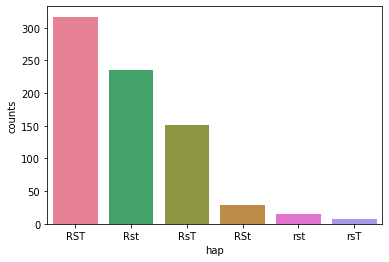

In [73]:
a = geno_assign2['hap'].value_counts().rename_axis('hap').reset_index(name='counts')
sns.barplot(x='hap', y='counts', data = a, palette = test)

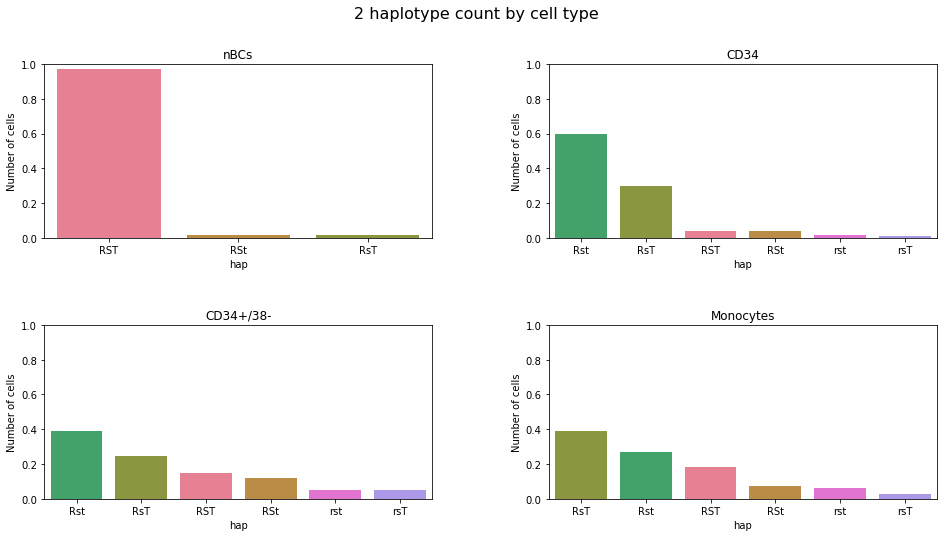

In [90]:
#Plot two haplotype data - second method
fig, axes = plt.subplots(2,2, figsize = (16,8))
fig.subplots_adjust(hspace = 0.5, wspace=.3)
ax = axes.ravel()
count = -1

for cell in celltypes:
    count += 1
    
    a = geno_assign2.loc[geno_assign2['Cell_type'].isin([cell])]['hap'].value_counts().rename_axis('hap').reset_index(name='counts')
    b = a['counts'].sum()
    a['proportion'] = a['counts']/b
    
    ax[count] = sns.barplot(x='hap', y='proportion', data = a, palette = test, ax = ax[count])
    ax[count].set_title(str(cell)) 
    ax[count].set_ylabel('Number of cells')
    ax[count].set_ylim(0,1)
    
fig.suptitle('2 haplotype count by cell type', fontsize=16)
fig.savefig('../Results/Haplotypes/Haplotype2_freq_celltype_colour.png',dpi=300)     
#plt.close() #Plot just goes to file and isn't displayed   

In [84]:
a

,hap,counts,proportion
0,RsT,43,0.387387
1,Rst,30,0.270270
2,RST,20,0.180180
3,RSt,8,0.072072
4,rst,7,0.063063
5,rsT,3,0.027027
